In this notebook, we will plot the results of the experiments comparing the LCEGP w/
lookahead PCS with the alternative contextual RS algorithms from the literature.

In these experiments, the true underlying model is a SingleTaskGP that is untrained.

In [1]:
import json
import os

import torch
from torch import Tensor

%matplotlib inline
import matplotlib.pyplot as plt

# current_dir = os.path.dirname(os.path.abspath(__file__))
current_dir = os.getcwd()

plot_kwargs = {
    "LCEGP": {"marker": "^", "color": u'#1f77b4'},  # 0
    "Li": {"color": u'#ff7f0e'},  # 1
    "Gao": {"color": u'#2ca02c'},  # 2
    "LCEGP_IKG": {"marker": "o", "color": u'#d62728'},  # 3
    "LCEGP_Adam": {"ls": "--", "marker": "+", "color": u'#9467bd'},  # 4
    "LCEGP_reuse": {"ls": "-.", "marker": "s", "color": u'#8c564b'},  # 5
    "ML_IKG": {"ls": "-.", "marker": "p", "color": u'#e377c2'},  # 6
    "LCEGP_PCS_apx": {"ls": "--", "marker": "h", "color": u'#7f7f7f'},  # 7
    "LCEGP_Matern": {"ls": "-.", "marker": "p", "color": u'#bcbd22'},  # 8
    "LCEGP_Scale": {"ls": "-.", "marker": "*", "color": u'#17becf'},  # 9
    "ST_PCS": {"ls": "-.", "marker": "d", "color": u'#d62728'},  # 10
    "ST_PCS_apx": {"ls": "--", "marker": "D", "color": u'#9467bd'},  # 11
    "ST_IKG": {"ls": "-", "marker": "v", "color": u'#2ca02c'},  # 12
    "Li_reeval": {"ls": "-.", "marker": "+", "color": u'#ff7f0e'},  # 13
    "ML_IKG_reeval": {"ls": "-.", "marker": "+", "color": u'#e377c2'},  # 14
    "LCEGP_EI": {"ls": "--", "marker": "+", "color": u'#1f77b4'},  # 15
    "ST_EI": {"ls": "--", "marker": "+", "color": u'#d62728'},  # 16
}

all_keys = list(plot_kwargs.keys())
plot_idcs = None
# plot_idcs = [10, 11, 12]  # original ST
# plot_idcs = [0, 13, 14]
plot_idcs = [0, 1, 2, 3, 6, 13, 14, 15]
moving_average_window = 5
plot_errors = False
figsize = (18, 12)


def plot_experiment(
    dirname: str, plot_idcs: list = plot_idcs, empirical_pcs: bool = False,
) -> Tensor:
    exp_dir = os.path.join(current_dir, dirname)
    config_path = os.path.join(exp_dir, "config.json")

    with open(config_path, "r") as f:
        config_dict = json.load(f)
        print(f"Config: \n {json.dumps(config_dict, indent=4)}")

    # get all the output files
    directory_list = os.listdir(exp_dir)
    output_files = [
        os.path.join(exp_dir, file) for file in directory_list if file[-3:] == ".pt"
    ]
    print(f"Found {len(output_files)} output files.")

    # plot final values, averaged over replications.
    # final values is a list of tensors, one tensor per label
    if empirical_pcs:
        key = "correct_selection"
    else:
        key = "pcs_estimates"

    output_lists = [list() for _ in all_keys]

    for out_path in output_files:
        out_dict = torch.load(out_path)
        label_idx = all_keys.index(out_dict["label"])
        output = out_dict[key].cpu()
        if empirical_pcs:
            # treating it as the expected PCS for now.
            output = output.mean(dim=-1)
        output_lists[label_idx].append(output)

    # calculate the mean and std for plotting
    key_counts = list()
    plot_means = list()
    plot_stds = list()
    for out_list in output_lists:
        try:
            out_tensor = torch.stack(out_list)
            key_counts.append(out_tensor.shape[0])
            mean = out_tensor.mean(dim=0)
            std = out_tensor.std(dim=0)
            if moving_average_window > 1:
                tmp_mean = torch.zeros_like(mean)
                tmp_std = torch.zeros_like(std)
                for i in range(tmp_mean.shape[0]):
                    l_ind = max(0, i - moving_average_window)
                    tmp_mean[i] = torch.mean(mean[l_ind: i+1])
                    tmp_std[i] = torch.mean(std[l_ind: i+1])
                mean = tmp_mean
                std = tmp_std
            plot_means.append(mean)
            plot_stds.append(std)
        except:
            key_counts.append(0)
            plot_means.append(None)
            plot_stds.append(None)

    print(f"Plotting {key_counts} outputs!")

    # plot
    fig = plt.figure(figsize=figsize)
    fig.patch.set_facecolor('xkcd:mint green')

    if plot_idcs is None:
        plot_idcs = range(len(key_counts))

    for i in plot_idcs:
        if plot_means[i] is None:
            continue
        if plot_errors:
            plt.errorbar(
                x=torch.arange(plot_means[i].shape[0]),
                y=plot_means[i],
                yerr=plot_stds[i],
                errorevery=5,
                label=all_keys[i],
                **plot_kwargs[all_keys[i]]
            )
        else:
            plt.plot(
                plot_means[i], label=all_keys[i], **plot_kwargs[all_keys[i]]
            )
    plt.grid()
    plt.legend()
    plt.show()
    return output_lists


Config: 
 {
    "iterations": 400,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 4,
    "num_contexts": 4,
    "num_fantasies": 0
}
Found 260 output files.
Plotting [30, 30, 30, 0, 0, 0, 30, 20, 0, 0, 20, 20, 20, 30, 30, 0, 0] outputs!
Config: 
 {
    "iterations": 400,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 4,
    "num_contexts": 4,
    "num_fantasies": 0
}
Found 260 output files.
Plotting [30, 30, 30, 0, 0, 0, 30, 20, 0, 0, 20, 20, 20, 30, 30, 0, 0] outputs!


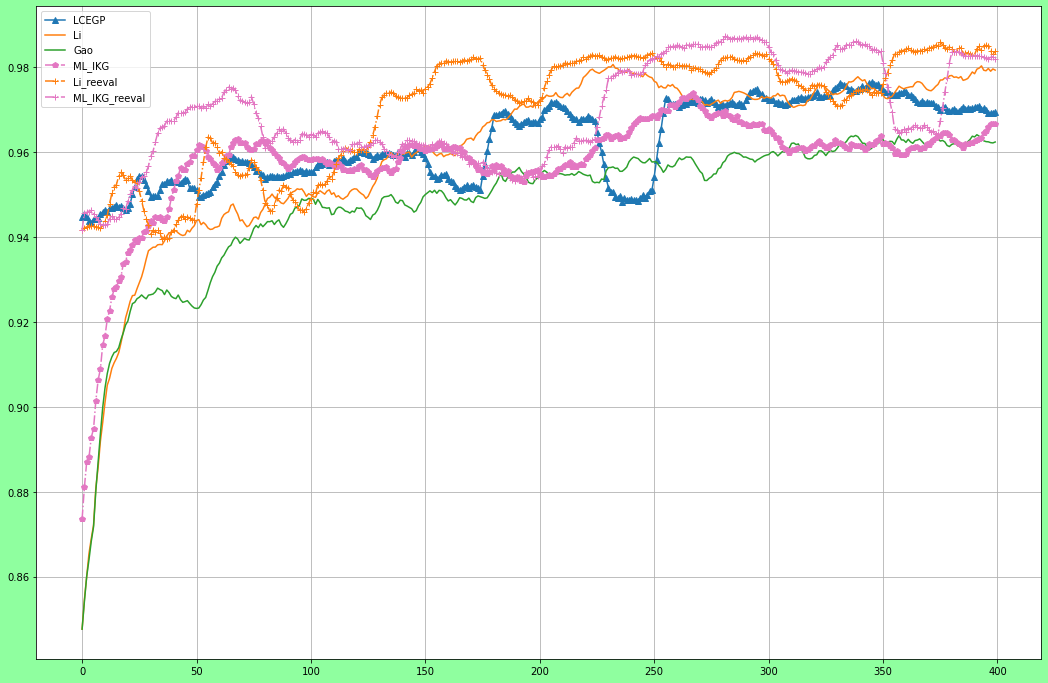

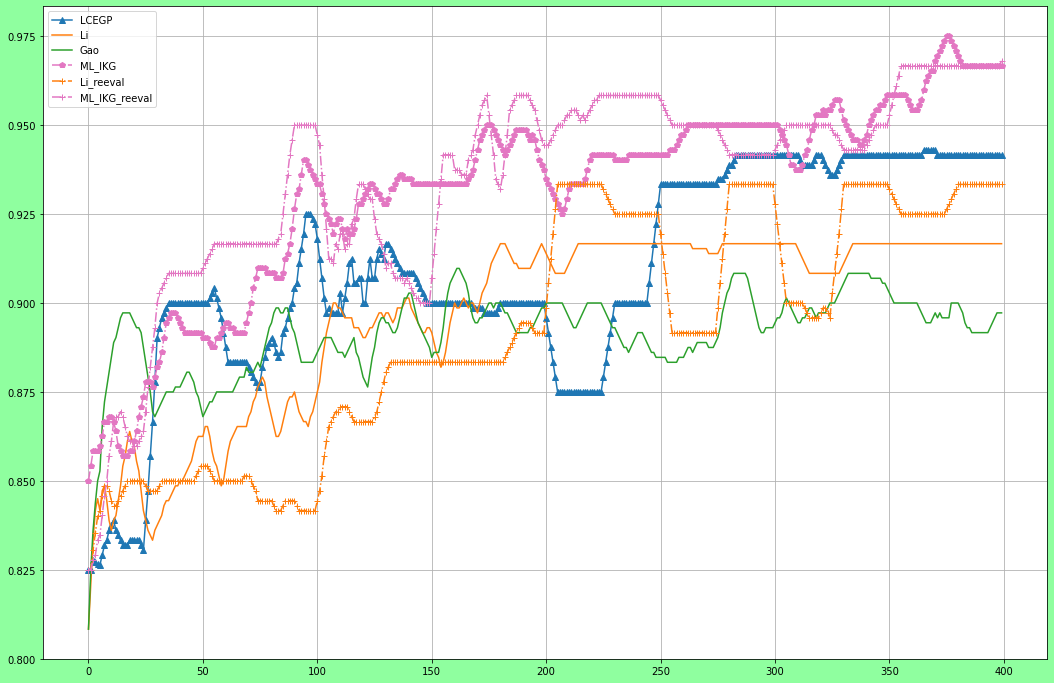

In [2]:
_ = plot_experiment("config_0")
_ = plot_experiment("config_0", empirical_pcs=True)

In [3]:
# _ = plot_experiment("config_00")
# _ = plot_experiment("config_00", empirical_pcs=True)


Config: 
 {
    "iterations": 400,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 4,
    "num_contexts": 10,
    "num_fantasies": 0
}
Found 260 output files.
Plotting [30, 30, 30, 0, 0, 0, 30, 0, 0, 0, 20, 20, 20, 30, 30, 0, 0] outputs!
Config: 
 {
    "iterations": 400,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 4,
    "num_contexts": 10,
    "num_fantasies": 0
}
Found 260 output files.
Plotting [30, 30, 30, 0, 0, 0, 30, 0, 0, 0, 20, 20, 20, 30, 30, 0, 0] outputs!


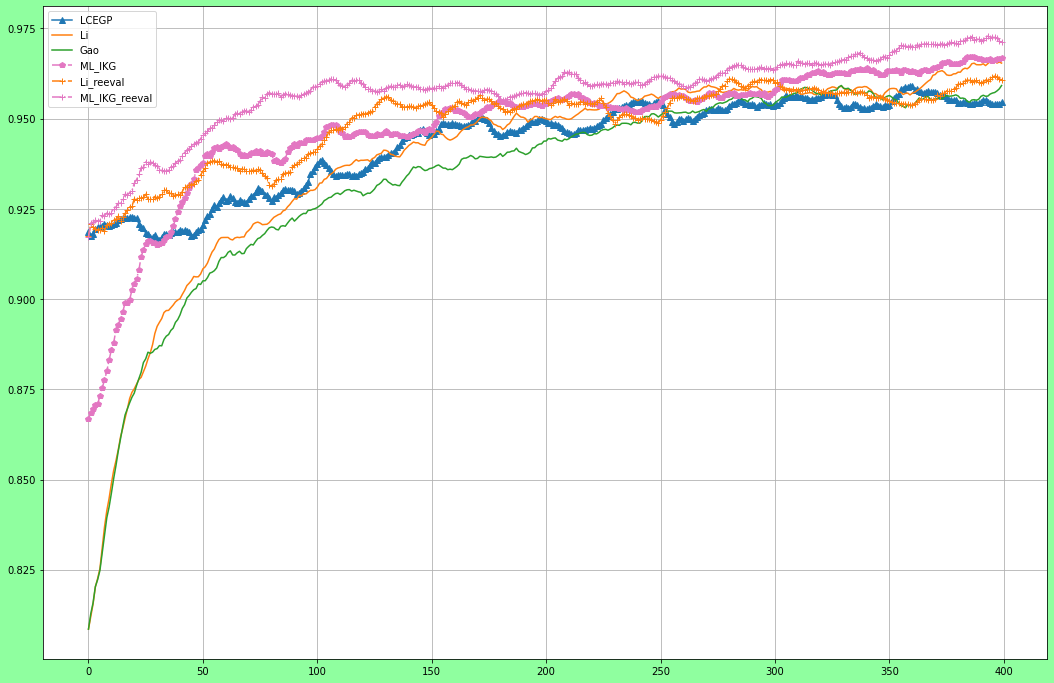

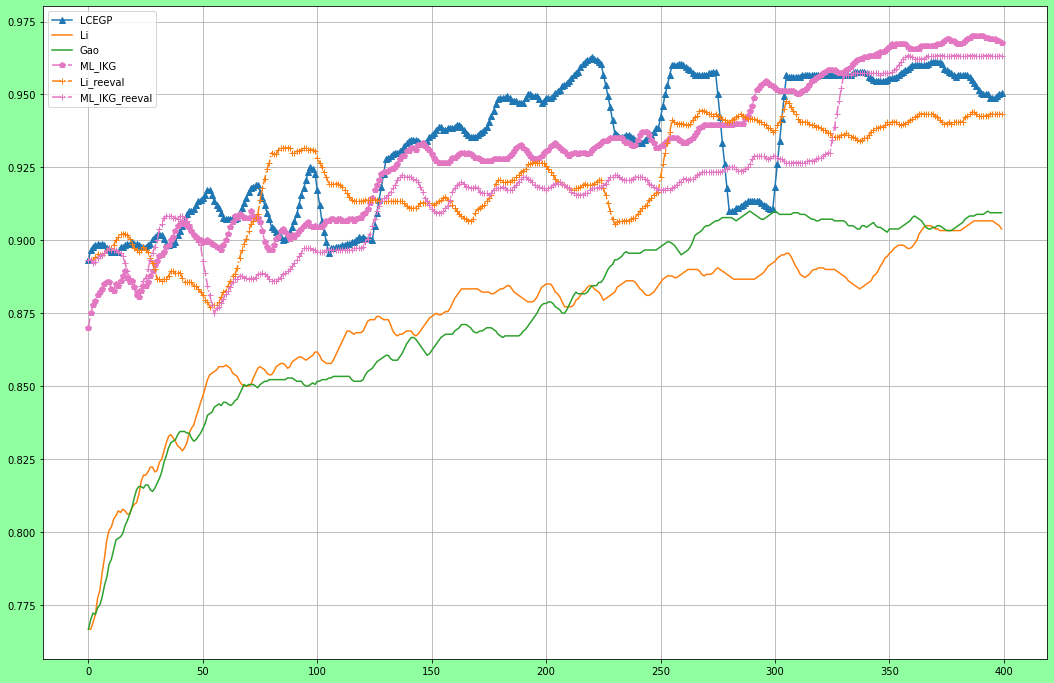

In [4]:
_ = plot_experiment("config_1")
_ = plot_experiment("config_1", empirical_pcs=True)

Config: 
 {
    "iterations": 400,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 10,
    "num_contexts": 4,
    "num_fantasies": 0
}
Found 260 output files.
Plotting [30, 30, 30, 0, 0, 0, 30, 20, 0, 0, 20, 20, 20, 30, 30, 0, 0] outputs!
Config: 
 {
    "iterations": 400,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 10,
    "num_contexts": 4,
    "num_fantasies": 0
}
Found 260 output files.
Plotting [30, 30, 30, 0, 0, 0, 30, 20, 0, 0, 20, 20, 20, 30, 30, 0, 0] outputs!


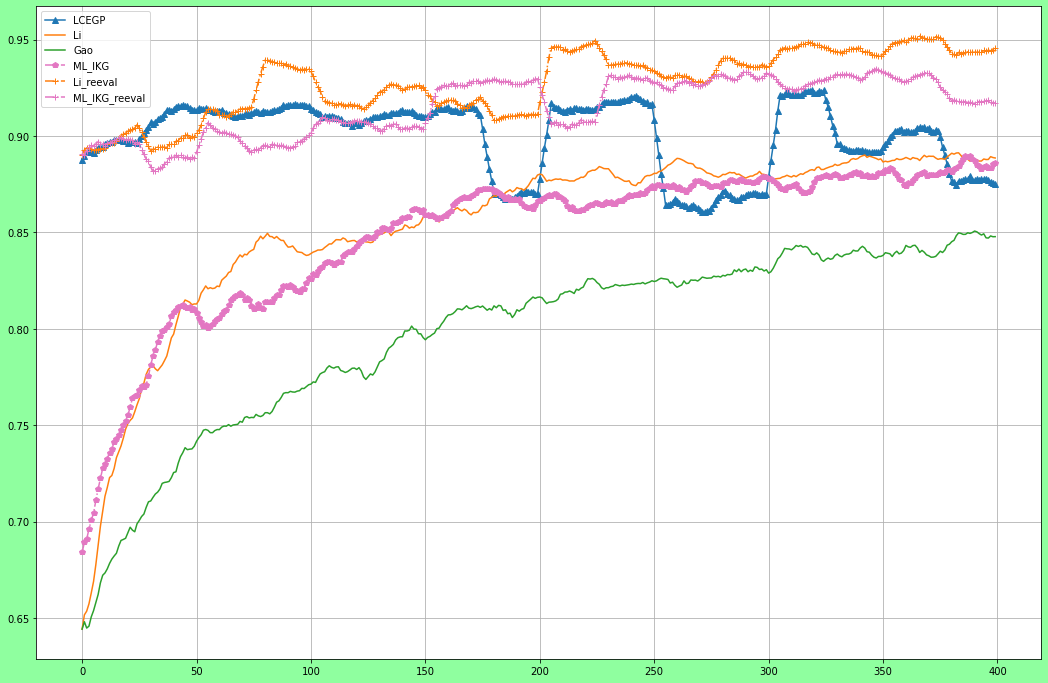

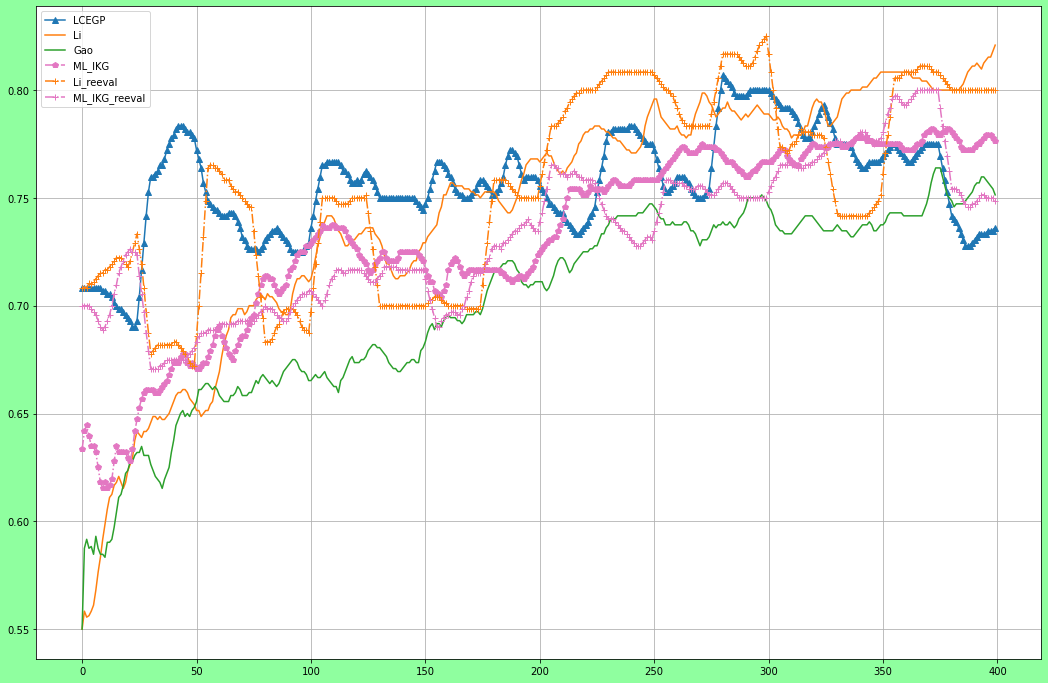

In [5]:
_ = plot_experiment("config_2")
_ = plot_experiment("config_2", empirical_pcs=True)

Config: 
 {
    "iterations": 400,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 10,
    "num_contexts": 10,
    "num_fantasies": 0,
    "batch_size": 5
}
Found 230 output files.
Plotting [30, 30, 30, 0, 0, 0, 30, 0, 0, 0, 20, 20, 20, 20, 30, 0, 0] outputs!
Config: 
 {
    "iterations": 400,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 10,
    "num_contexts": 10,
    "num_fantasies": 0,
    "batch_size": 5
}
Found 230 output files.
Plotting [30, 30, 30, 0, 0, 0, 30, 0, 0, 0, 20, 20, 20, 20, 30, 0, 0] outputs!


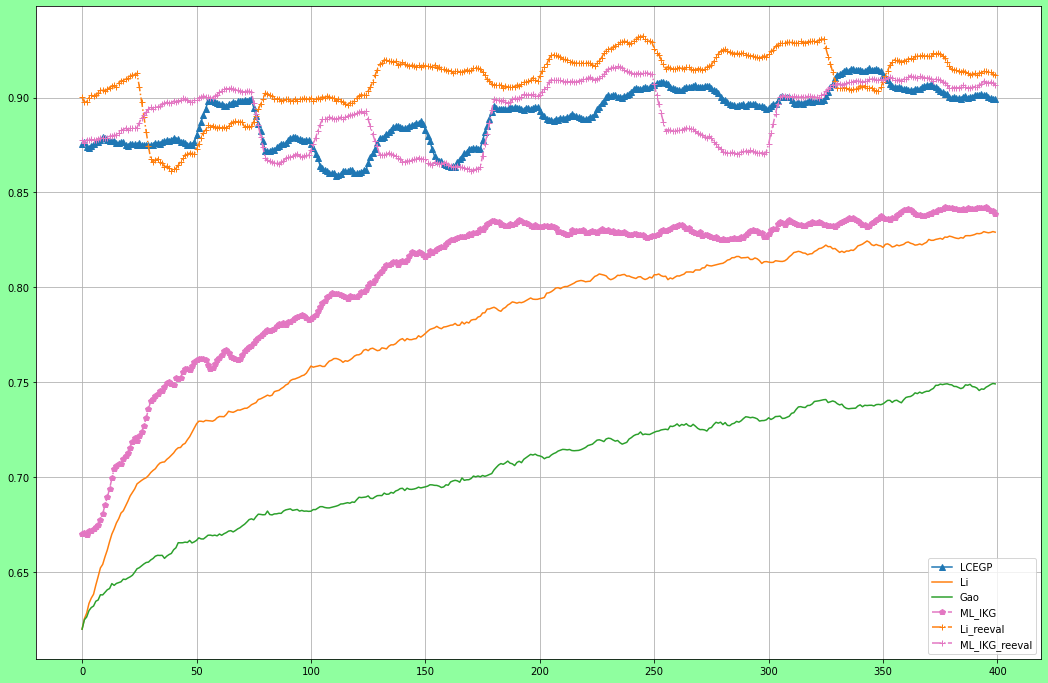

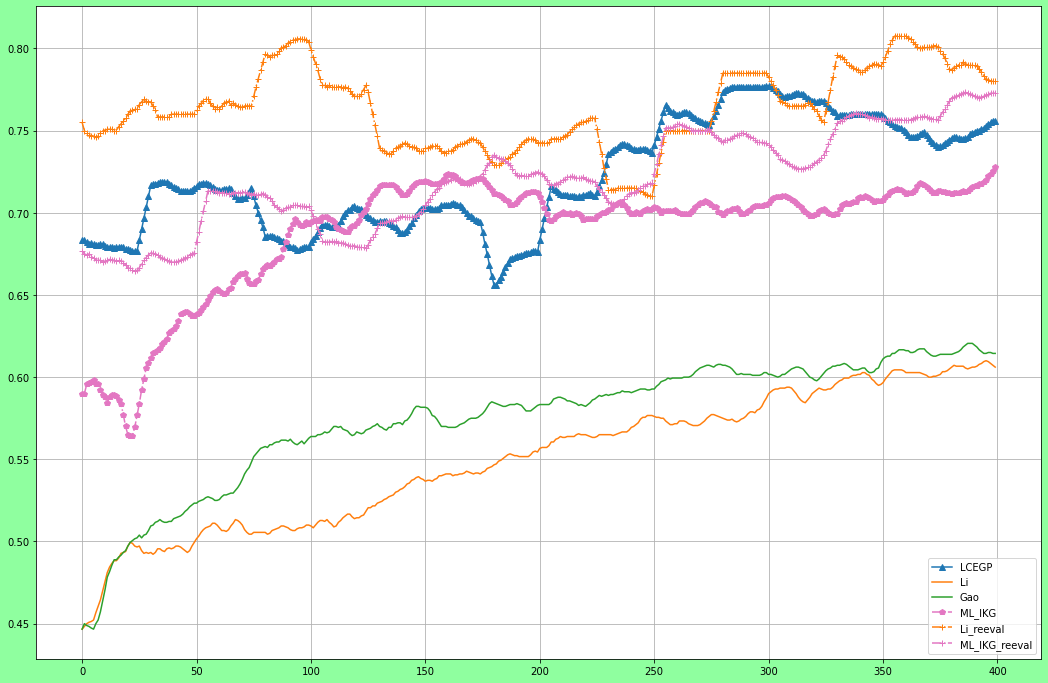

In [6]:
_ = plot_experiment("config_3")
_ = plot_experiment("config_3", empirical_pcs=True)

Config: 
 {
    "iterations": 400,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 10,
    "num_contexts": 20,
    "num_fantasies": 0,
    "batch_size": 5
}
Found 210 output files.
Plotting [30, 30, 30, 0, 0, 0, 30, 0, 0, 0, 20, 0, 20, 0, 30, 0, 0] outputs!
Config: 
 {
    "iterations": 400,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 10,
    "num_contexts": 20,
    "num_fantasies": 0,
    "batch_size": 5
}
Found 210 output files.
Plotting [30, 30, 30, 0, 0, 0, 30, 0, 0, 0, 20, 0, 20, 0, 30, 0, 0] outputs!


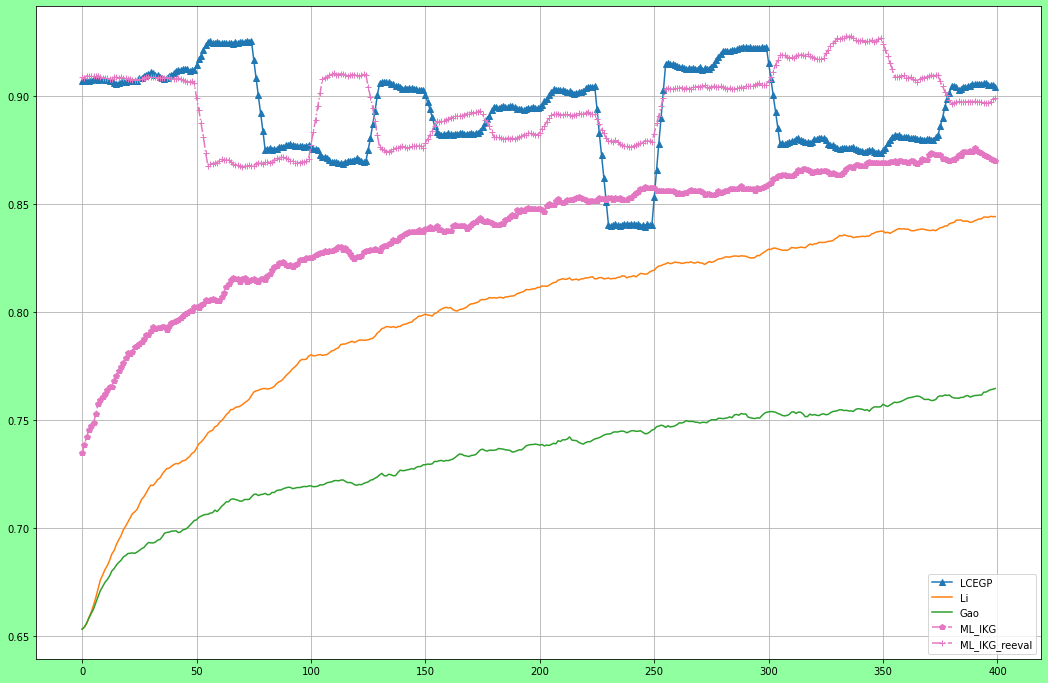

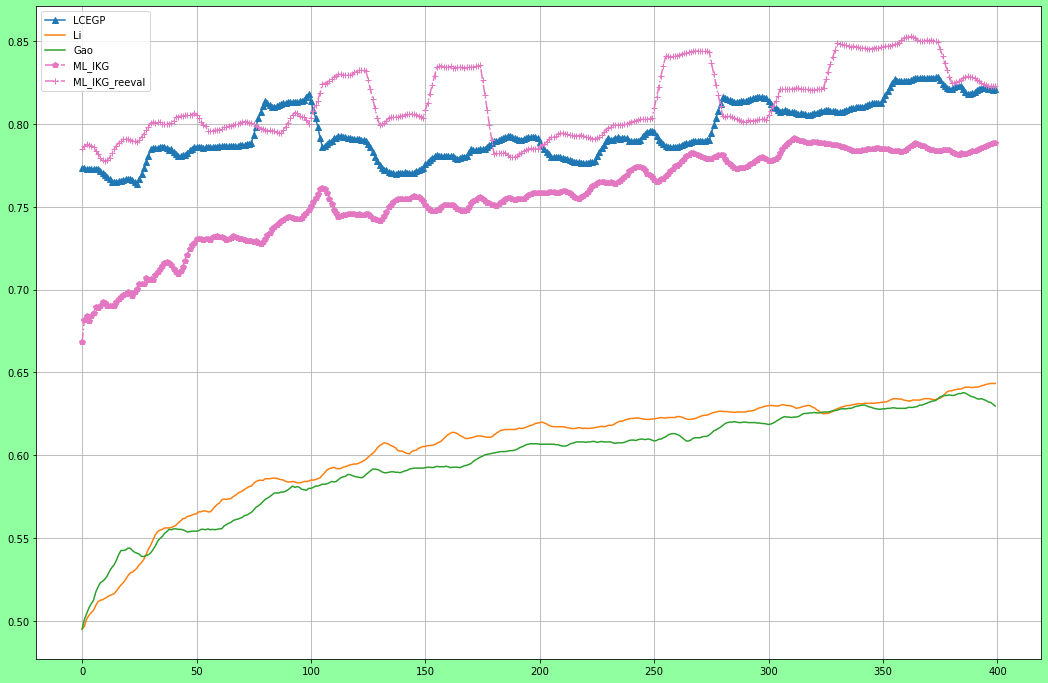

In [7]:
_ = plot_experiment("config_4")
_ = plot_experiment("config_4", empirical_pcs=True)

Config: 
 {
    "iterations": 200,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 4,
    "num_contexts": 4,
    "num_fantasies": 0,
    "ground_truth_kwargs": {
        "function": "branin"
    }
}
Found 259 output files.
Plotting [30, 30, 30, 0, 0, 0, 30, 20, 0, 0, 20, 19, 20, 0, 20, 20, 20] outputs!
Config: 
 {
    "iterations": 200,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 4,
    "num_contexts": 4,
    "num_fantasies": 0,
    "ground_truth_kwargs": {
        "function": "branin"
    }
}
Found 259 output files.
Plotting [30, 30, 30, 0, 0, 0, 30, 20, 0, 0, 20, 19, 20, 0, 20, 20, 20] outputs!


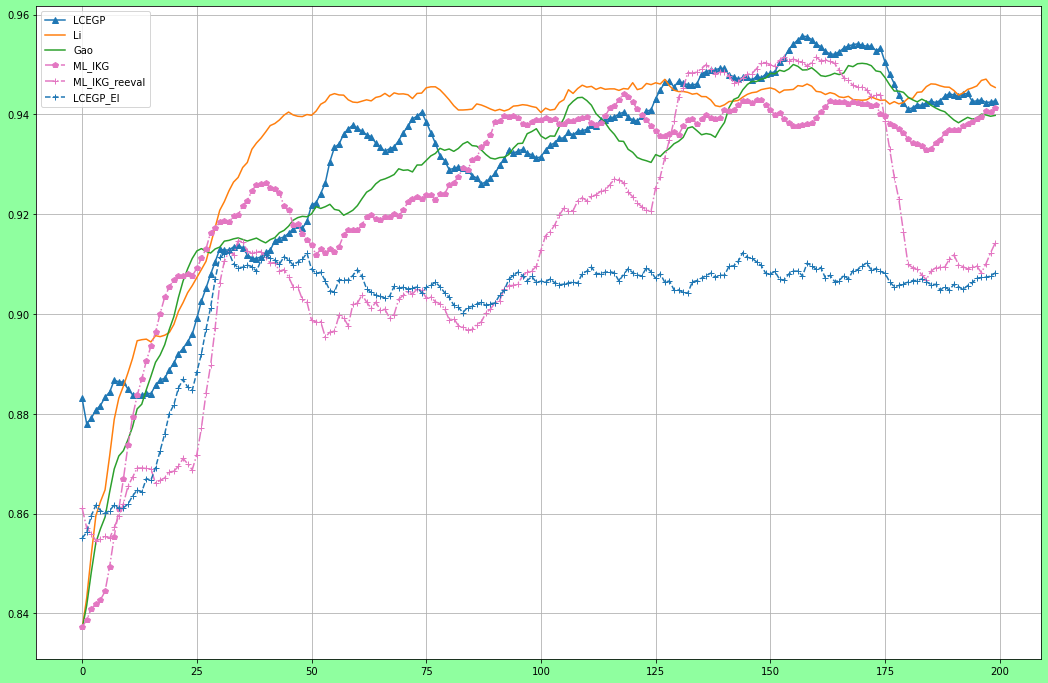

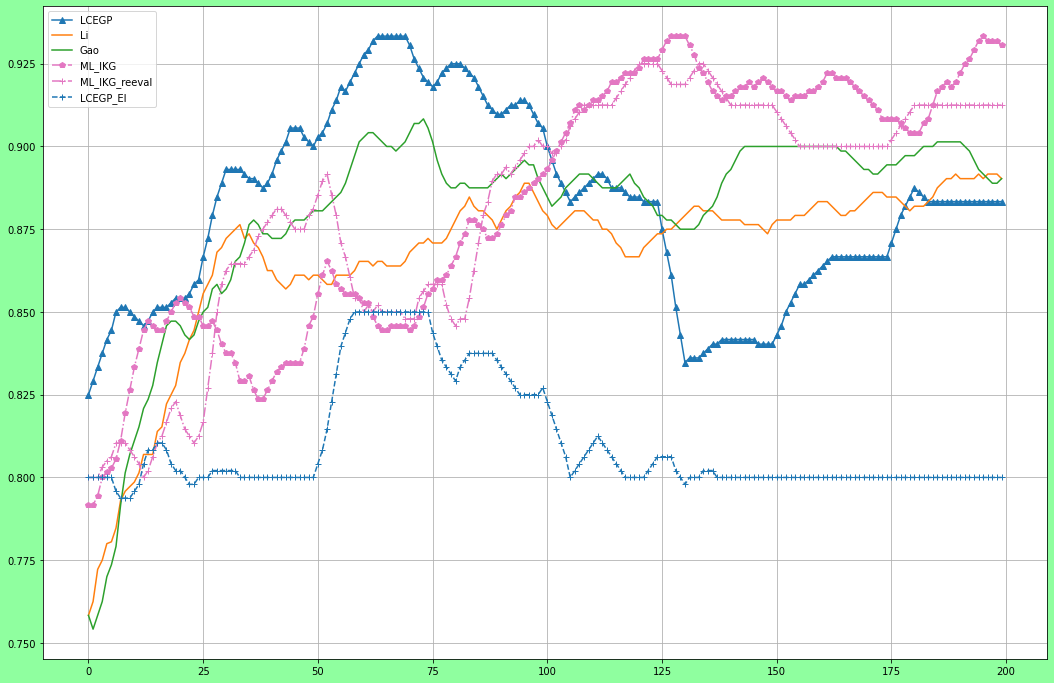

In [8]:
_ = plot_experiment("config_b_0")
_ = plot_experiment("config_b_0", empirical_pcs=True)

Config: 
 {
    "iterations": 400,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 10,
    "num_contexts": 10,
    "num_fantasies": 0,
    "ground_truth_kwargs": {
        "function": "branin"
    },
    "batch_size": 5
}
Found 219 output files.
Plotting [30, 30, 30, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 20, 20, 20, 0] outputs!
Config: 
 {
    "iterations": 400,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 10,
    "num_contexts": 10,
    "num_fantasies": 0,
    "ground_truth_kwargs": {
        "function": "branin"
    },
    "batch_size": 5
}
Found 219 output files.
Plotting [30, 30, 30, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 20, 20, 20, 0] outputs!


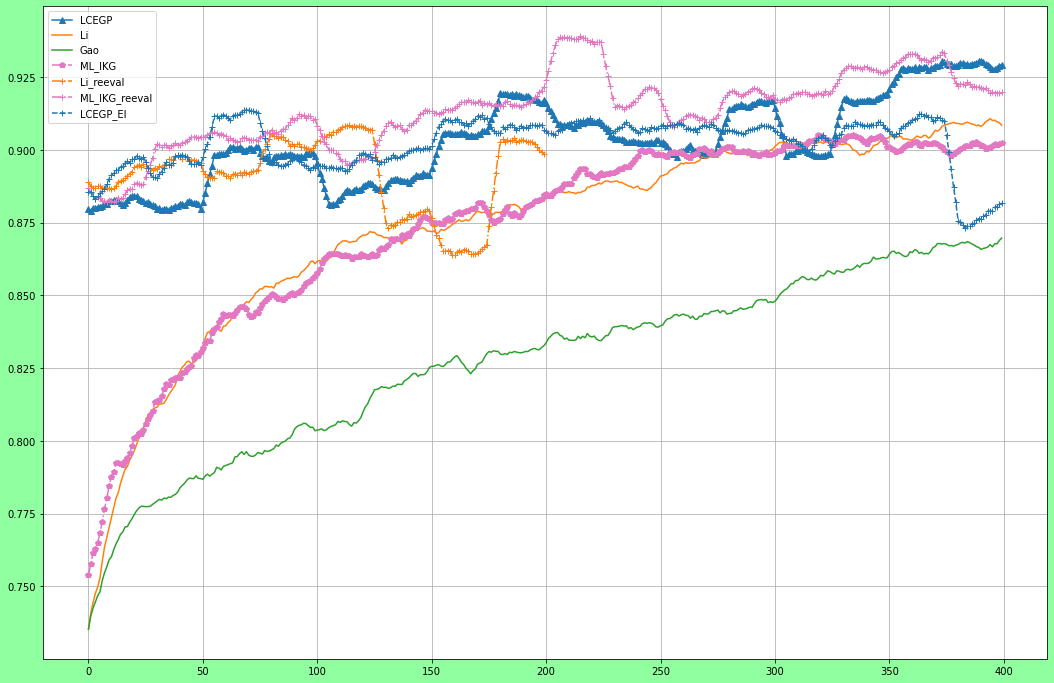

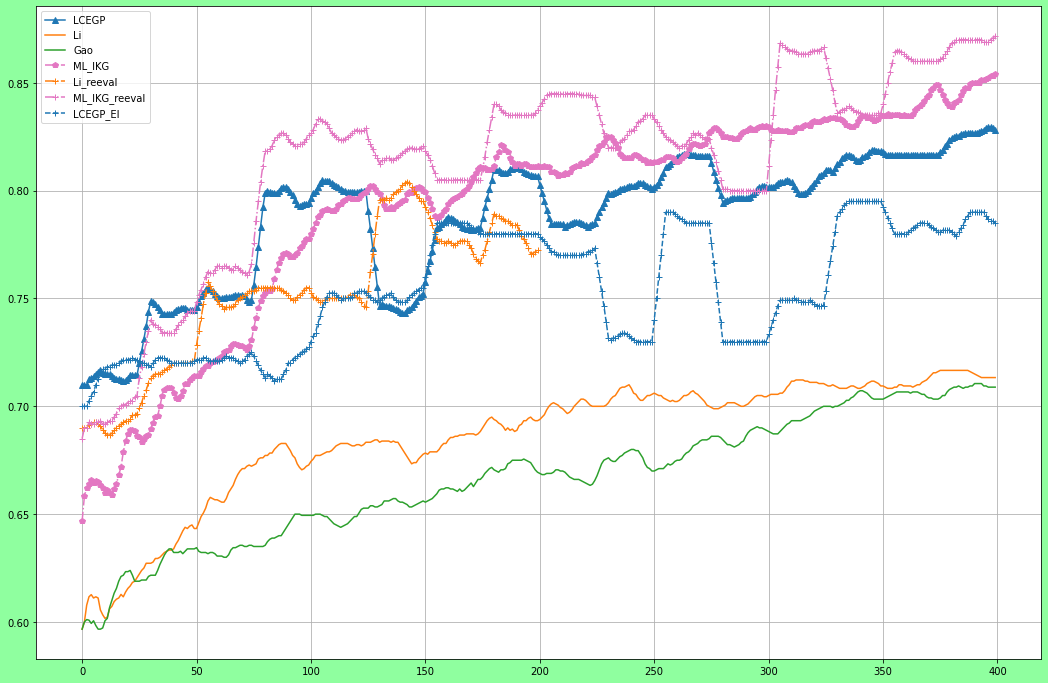

In [9]:
_ = plot_experiment("config_b_3")
_ = plot_experiment("config_b_3", empirical_pcs=True)

Config: 
 {
    "iterations": 200,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 10,
    "num_contexts": 20,
    "num_fantasies": 0,
    "ground_truth_kwargs": {
        "function": "branin"
    },
    "batch_size": 5
}
Found 185 output files.
Plotting [30, 30, 30, 15, 0, 0, 30, 0, 0, 0, 16, 0, 12, 0, 2, 20, 0] outputs!
Config: 
 {
    "iterations": 200,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 10,
    "num_contexts": 20,
    "num_fantasies": 0,
    "ground_truth_kwargs": {
        "function": "branin"
    },
    "batch_size": 5
}
Found 185 output files.
Plotting [30, 30, 30, 15, 0, 0, 30, 0, 0, 0, 16, 0, 12, 0, 2, 20, 0] outputs!


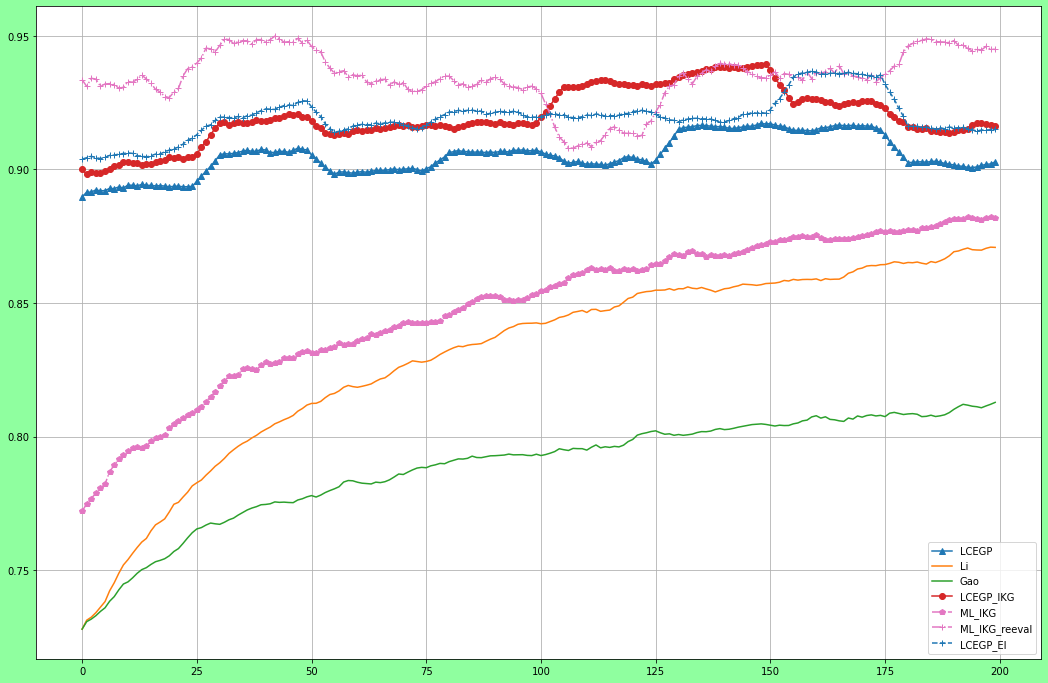

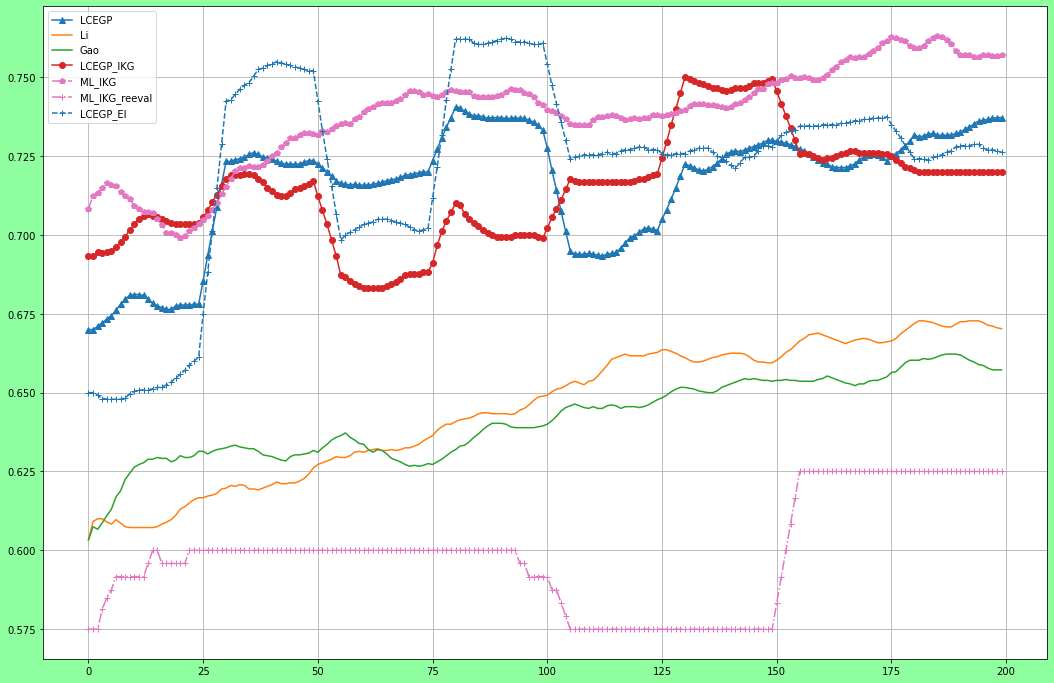

In [10]:
_ = plot_experiment("config_b_4")
_ = plot_experiment("config_b_4", empirical_pcs=True)

In [11]:
# _ = plot_experiment("config_b_5")
# _ = plot_experiment("config_b_5", empirical_pcs=True)

Config: 
 {
    "iterations": 400,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 10,
    "num_contexts": 10,
    "context_dim": 5,
    "num_fantasies": 0,
    "ground_truth_kwargs": {
        "function": "hartmann"
    },
    "batch_size": 5
}
Found 121 output files.
Plotting [30, 30, 30, 1, 0, 0, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] outputs!
Config: 
 {
    "iterations": 400,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 10,
    "num_contexts": 10,
    "context_dim": 5,
    "num_fantasies": 0,
    "ground_truth_kwargs": {
        "function": "hartmann"
    },
    "batch_size": 5
}
Found 121 output files.
Plotting [30, 30, 30, 1, 0, 0, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] outputs!


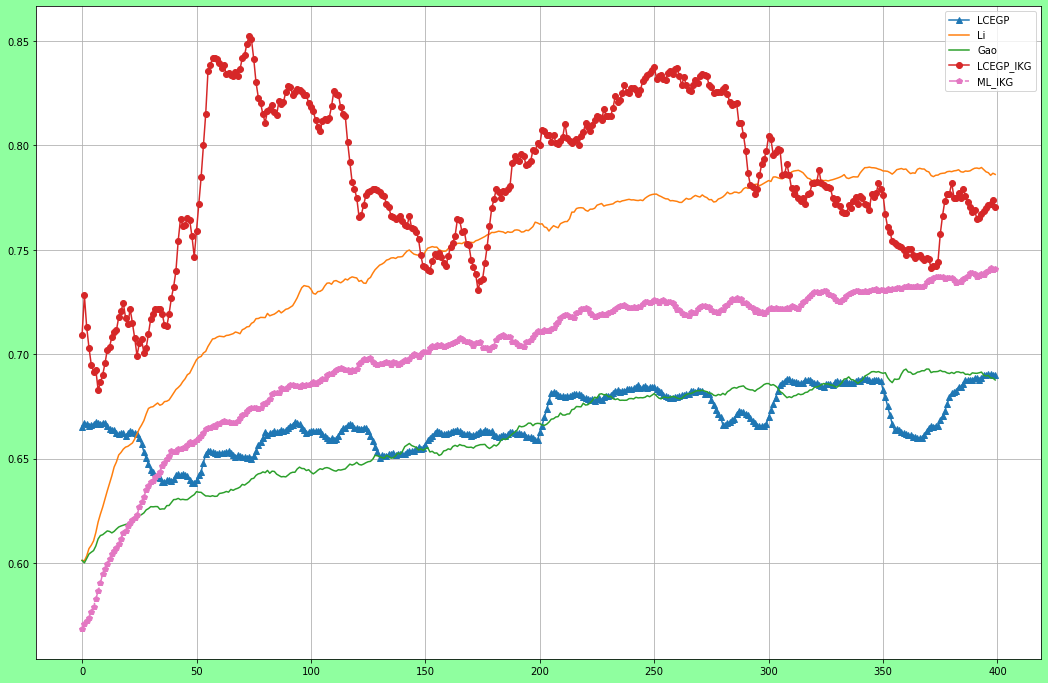

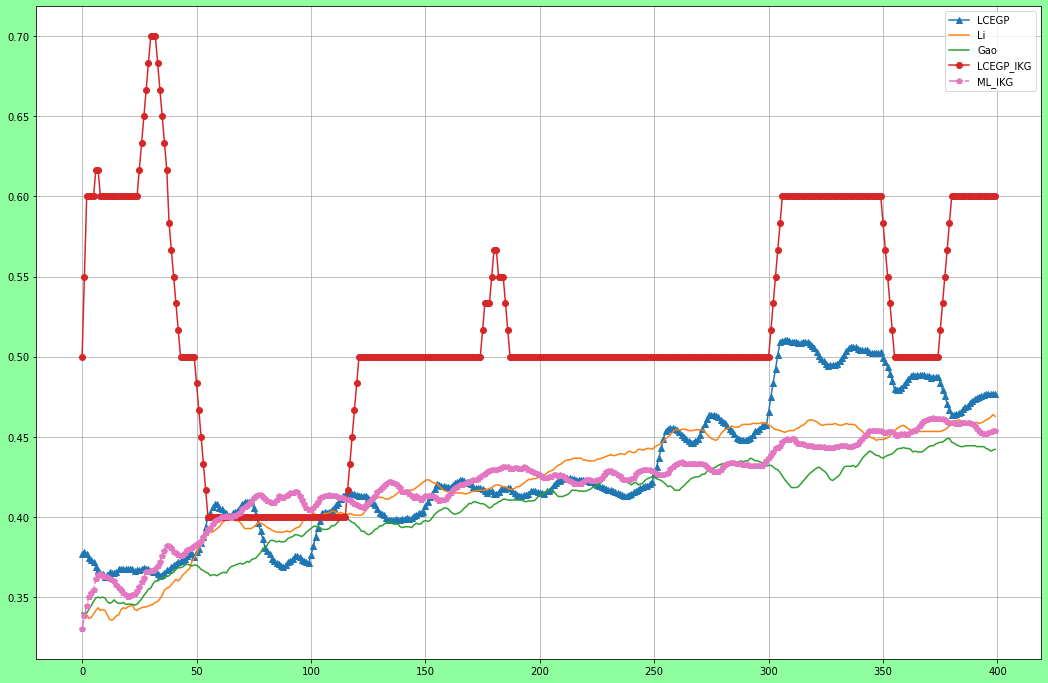

In [12]:
_ = plot_experiment("config_h_3")
_ = plot_experiment("config_h_3", empirical_pcs=True)

Config: 
 {
    "iterations": 400,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 10,
    "num_contexts": 20,
    "context_dim": 5,
    "num_fantasies": 0,
    "ground_truth_kwargs": {
        "function": "hartmann"
    },
    "batch_size": 5
}
Found 123 output files.
Plotting [30, 30, 30, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0] outputs!
Config: 
 {
    "iterations": 400,
    "fit_frequency": 25,
    "fit_tries": 10,
    "num_arms": 10,
    "num_contexts": 20,
    "context_dim": 5,
    "num_fantasies": 0,
    "ground_truth_kwargs": {
        "function": "hartmann"
    },
    "batch_size": 5
}
Found 123 output files.
Plotting [30, 30, 30, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0] outputs!


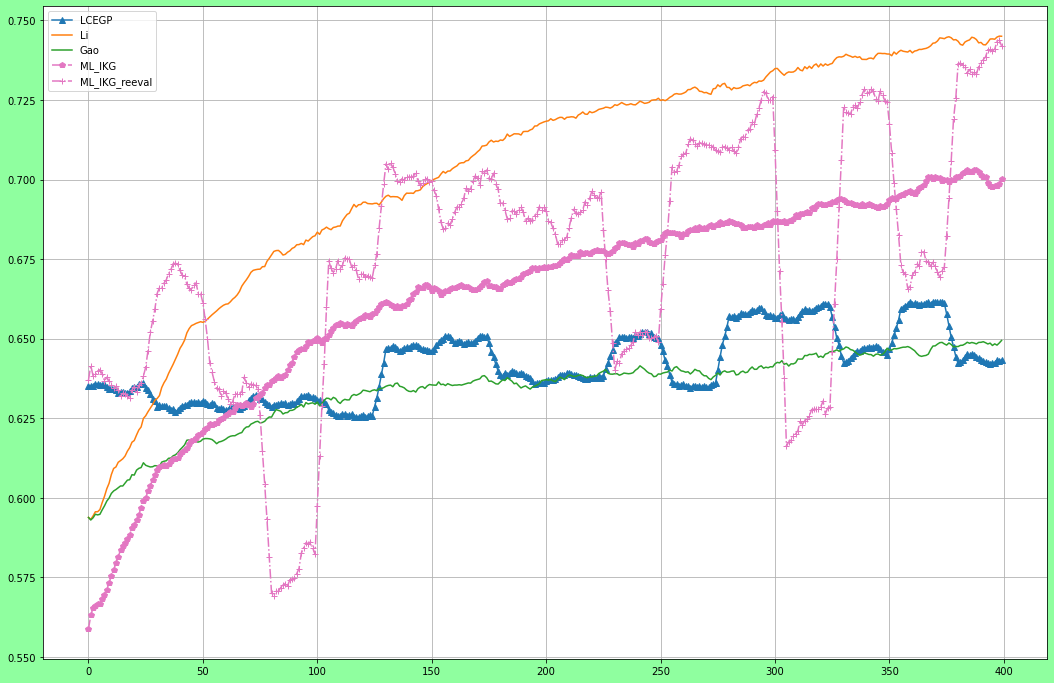

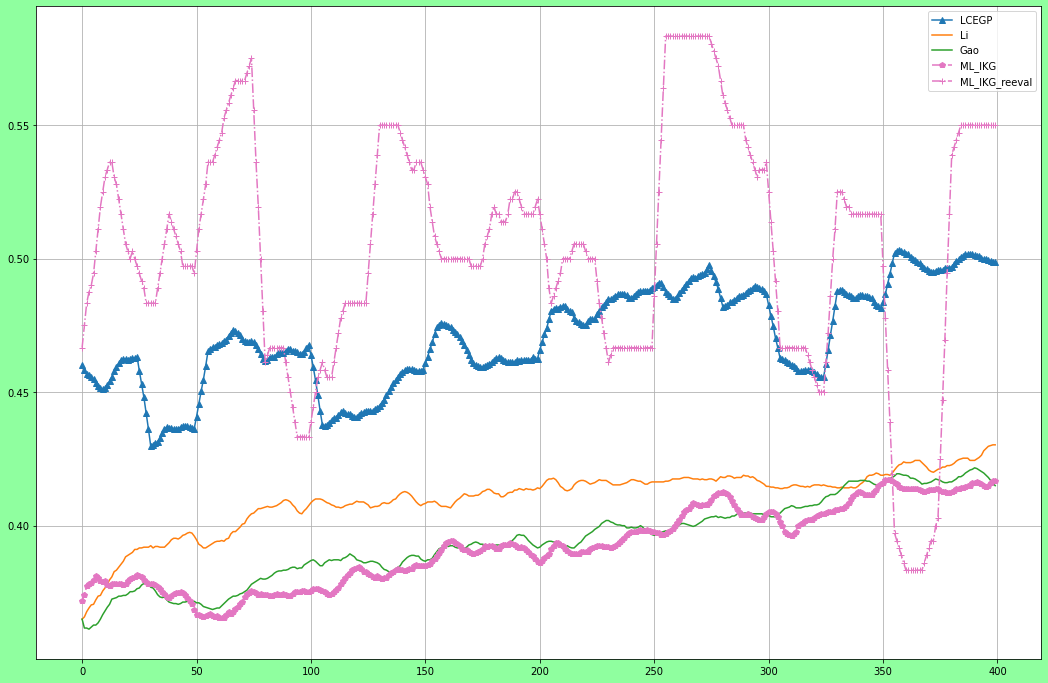

In [13]:
_ = plot_experiment("config_h_4")
_ = plot_experiment("config_h_4", empirical_pcs=True)

In [14]:
# _ = plot_experiment("config_h_5")
# _ = plot_experiment("config_h_5", empirical_pcs=True)